# 02 - Expression QC and PCA

Load the processed TPM matrix, perform basic quality-checks, and derive PCA embeddings for downstream visualization or clustering notebooks.


In [12]:
from __future__ import annotations

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "README.md").exists():
            return candidate
    raise FileNotFoundError("Unable to locate repository root (README.md not found)")


PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.config import ProjectConfig
from src.data_loading import load_expression_tpm

config = ProjectConfig()
PROCESSED_DATA_DIR = config.processed_data_dir
EXPRESSION_PATH = PROCESSED_DATA_DIR / "tcga_brca_expression_tpm.tsv.gz"
EXPRESSION_PATH


PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_expression_tpm.tsv.gz')

In [13]:
expression_df = load_expression_tpm()
expression_df.shape


(60660, 1197)

## Basic QC summaries

Capture simple dataset-level stats (samples, genes, sequencing depth proxies) to confirm nothing exploded during preprocessing.


In [14]:
n_genes, n_samples = expression_df.shape
sample_totals = expression_df.sum(axis=0)

summary = pd.Series(
    {
        "n_genes": n_genes,
        "n_samples": n_samples,
        "median_sample_depth": float(sample_totals.median()),
        "min_sample_depth": float(sample_totals.min()),
        "max_sample_depth": float(sample_totals.max()),
    }
)
summary


n_genes                    60660.0
n_samples                   1197.0
median_sample_depth     57331767.0
min_sample_depth        19225117.0
max_sample_depth       114015705.0
dtype: float64

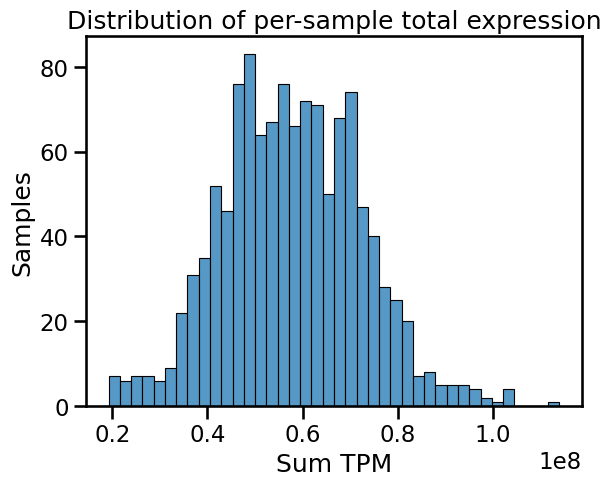

In [15]:
ax = sns.histplot(sample_totals, bins=40)
ax.set_title("Distribution of per-sample total expression")
ax.set_xlabel("Sum TPM")
_ = ax.set_ylabel("Samples")


## Preprocess matrix for PCA

Use the shared preprocessing helpers (mean filter, log transform, z-score scaling) to stabilize the expression values.


In [16]:
from src.preprocessing import filter_low_expression, log_transform, scale_features

filtered_df = filter_low_expression(expression_df, min_mean=1.0)
log_df = log_transform(filtered_df, pseudo_count=1.0)
scaled_df = scale_features(log_df)
filtered_df.shape, scaled_df.shape


((35790, 1197), (35790, 1197))

## Principal component analysis

Run PCA on the scaled expression matrix (samples as rows). Keep 50 components for downstream manifold learning.


In [17]:
from src.dimensionality_reduction import run_pca

n_components = 50
pca_df, pca_model = run_pca(scaled_df, n_components=n_components, return_model=True)
explained_variance = pd.Series(pca_model.explained_variance_ratio_, index=pca_df.columns)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
ba295155-272e-43eb-9d6a-e4c9c392e68b,66.881381,10.464202,-17.882775,24.450980,-34.534961,12.962275,-5.833964,27.902865,25.287797,-1.656168,...,4.840135,-9.810804,5.326876,-1.743993,10.895772,-1.771303,2.014357,-0.877309,0.184497,-3.534204
8d1641ea-7552-4d23-9298-094e0056386a,32.429013,-9.957598,40.264804,42.590246,-21.292736,55.190396,-33.987849,3.572891,0.974376,20.818672,...,-1.828826,-6.862730,4.830118,-9.513705,6.407914,-6.499774,-4.540029,-2.748677,-3.104844,1.421216
2f51534b-248b-4999-bc3f-e42a2e98332e,-87.738503,39.949205,46.913361,-59.784433,6.412864,-62.221974,-7.556203,22.414156,21.887043,-7.342581,...,7.690612,-6.034682,-29.825285,-0.573876,24.762176,-20.917960,-2.107538,3.631840,-2.675258,8.189914
b321a3f5-043d-42c6-8c9d-5784d45cb85c,58.511724,9.020735,-12.361333,47.892200,76.432903,-41.735964,17.798618,19.477678,13.830445,-26.064546,...,15.193230,3.339026,4.397652,-0.649963,0.078738,8.589395,5.984064,2.373127,4.694300,-4.044868
cafc9e36-c5f0-45df-ad03-16210ff0d870,91.537910,34.798539,-5.758935,18.729015,-18.983191,20.311883,-31.539405,23.071203,5.154782,2.454015,...,13.733020,-3.224252,9.158292,-0.976767,1.603692,-1.013049,-11.823112,-5.078651,10.120465,-7.915902


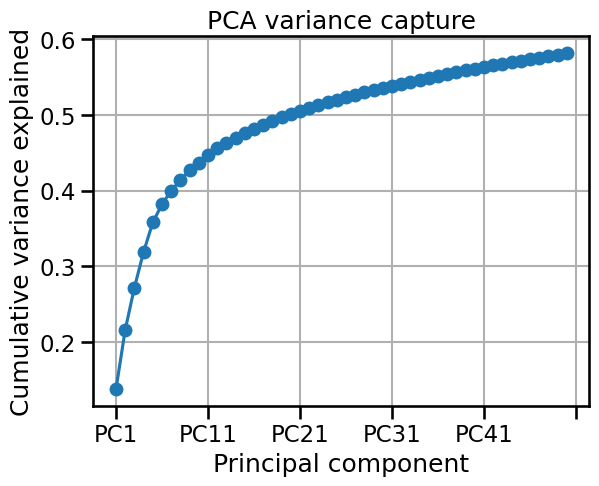

In [18]:
ax = explained_variance.cumsum().plot(marker='o')
ax.set_ylabel('Cumulative variance explained')
ax.set_xlabel('Principal component')
ax.set_title('PCA variance capture')
ax.grid(True)


Text(0, 0.5, 'PC2')

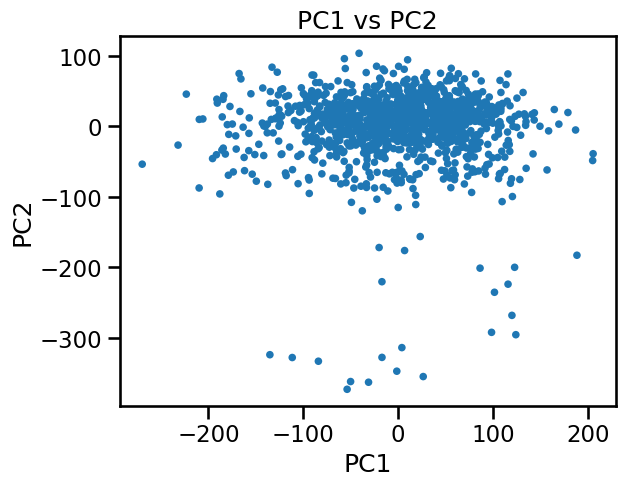

In [19]:
ax = sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    s=30,
    edgecolor="none",
)
ax.set_title("PC1 vs PC2")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")


Text(0, 0.5, 'PC3')

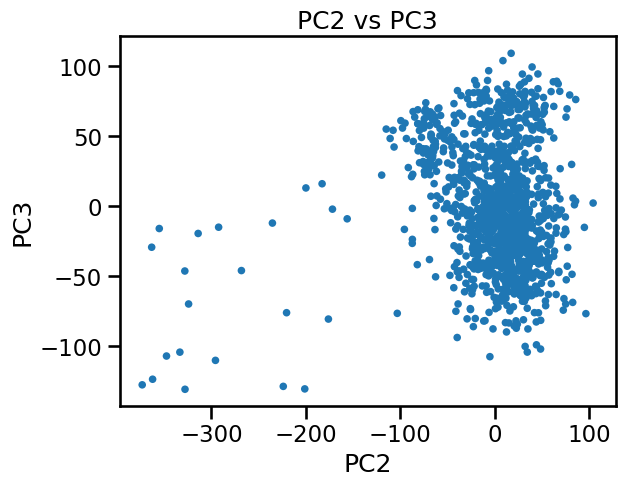

In [20]:
ax = sns.scatterplot(
    x=pca_df["PC2"],
    y=pca_df["PC3"],
    s=30,
    edgecolor="none",
)
ax.set_title("PC2 vs PC3")
ax.set_xlabel("PC2")
ax.set_ylabel("PC3")


Text(0, 0.5, 'PC4')

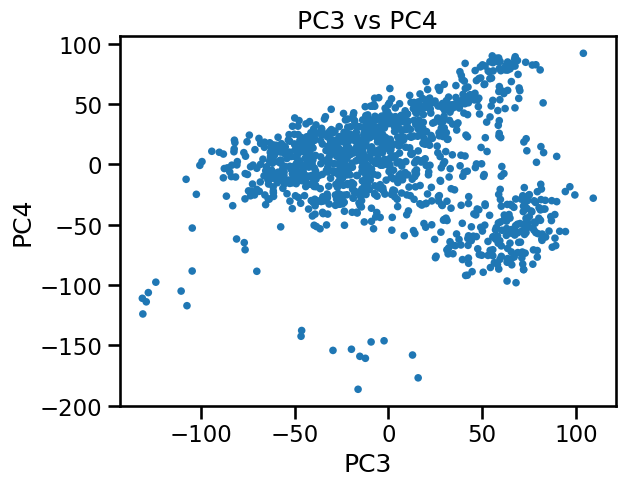

In [21]:
ax = sns.scatterplot(
    x=pca_df["PC3"],
    y=pca_df["PC4"],
    s=30,
    edgecolor="none",
)
ax.set_title("PC3 vs PC4")
ax.set_xlabel("PC3")
ax.set_ylabel("PC4")


## Persist PCA scores for downstream notebooks


In [22]:
pca_output_path = PROCESSED_DATA_DIR / "tcga_brca_pca_scores.tsv.gz"
pca_df.to_csv(pca_output_path, sep="	", compression="gzip")
pca_output_path

PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_pca_scores.tsv.gz')